# Make hex Difference Maps

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
import scipy.stats
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.ticker import FuncFormatter
from matplotlib.lines import Line2D
from matplotlib.ticker import AutoMinorLocator
import rioxarray as rxr
import pickle

In [2]:
%matplotlib inline

In [3]:
plt.rcParams['figure.facecolor']='w'
plt.rcParams['axes.facecolor']='w'
plt.rcParams['savefig.facecolor']='w'

plt.rcParams['font.size'] = '12'

In [4]:
pd.set_option('display.max_columns', None)

## Load in the Data:

In [7]:
outline_nolakes = pd.read_pickle('../../../data/site_outlines/tuol_outline_nolakes.pkl')

/Users/Hannah/micromamba/envs/analysis_2023/lib/python3.9/pickle.py:1717: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  setstate(state)


In [10]:
atl06sr_gdf = pd.read_pickle('../../data/ATL06sr/tuolumne_all_sr-atl06-09282022_processed_bicubic_snowonaso.pkl')

outline_gdf = pd.read_pickle('../../../data/site_outlines/tuolumne_outline_32611.pkl')
outline_nolakes = pd.read_pickle('../../../data/site_outlines/tuol_outline_nolakes.pkl')
lakes_tuol = pd.read_pickle('../../../data/misc/lakes_tuolumne.pkl')

snwd = pickle.load(open('../../data/CDEC/cdec_gdf.pkl', 'rb'))

aso_gdf = pickle.load(open('../../../data/misc/aso_dates.pkl', 'rb'))

cdec_geom = pickle.load(open('../../data/CDEC/cdec_geometries.pkl', 'rb'))
streamlines_tuol = pd.read_pickle('../../../data/misc/streamlines_tuol.pkl')

hetch = pd.read_pickle('../../../data/misc/hetch_hetchy.pkl')

tuol_reverse = pd.read_pickle('../../../data/misc/tuol_reverse.pkl')

streamlines_tuol = pd.read_pickle('../../../data/misc/streamlines_tuol.pkl')

/Users/Hannah/micromamba/envs/analysis_2023/lib/python3.9/pickle.py:1717: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  setstate(state)
/Users/Hannah/micromamba/envs/analysis_2023/lib/python3.9/pickle.py:1717: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  setstate(state)
/var/folders/yr/1f67jccn6hl_lyxnqy7qjpq40000gp/T/ipykernel_886/2121439962.py:9: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  aso_gdf = pickle.load(open('../../../data/misc/aso_dates.pkl', 'rb'))
/var/folders/yr/1f67jccn6hl_lyxnqy7qjpq40000gp/T/ipykernel_886/2121439962.py:11: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  cdec_geom = pickle.load(open('../../data/CDEC/cdec_ge

In [11]:
hillshade = rxr.open_rasterio('../../../data/lidar/tuolumne/snow_off/ASO_3M_PCDTM_USCATE_20191010_studyextent_100m_hillshade.tif', masked=True).squeeze()
dtm = rxr.open_rasterio('../../../data/lidar/tuolumne/snow_off/ASO_3M_PCDTM_USCATE_20191010_studyextent_100m.tif', masked=True).squeeze()

## Filter Outliers  
Using David's code  
Less concerned about doing this since I use the Median in my anayses

In [12]:
atl06sr_gdf['zscore'] = (atl06sr_gdf['diff_plus_bicubic'] - atl06sr_gdf['diff_plus_bicubic'].mean()) / atl06sr_gdf['diff_plus_bicubic'].std()

zscore_thresh = 3
absdiff_thresh = 5.0

In [13]:
# trying to get different zscore values for snow on versus snow off values

atl06_idx = (atl06sr_gdf['zscore'].abs() <= zscore_thresh)

inner_snowoff_idx = (atl06sr_gdf['zscore'].abs() <= zscore_thresh) & \
    (atl06sr_gdf['diff_plus_bicubic'].abs() <=absdiff_thresh) & \
    (atl06sr_gdf['snow_presence'] == 0)

inner_snowon_idx = (atl06sr_gdf['zscore'].abs() <= zscore_thresh) & \
    (atl06sr_gdf['diff_plus_bicubic'].abs() <=absdiff_thresh) & \
    (atl06sr_gdf['snow_presence'] == 1)

In [14]:
atl06sr_gdf_inner = atl06sr_gdf[atl06_idx]

### Create the hex map using code from GDA 2021  
https://github.com/UW-GDA

Text(0.5, 1.0, 'ATL06SR Snow On - DEM')

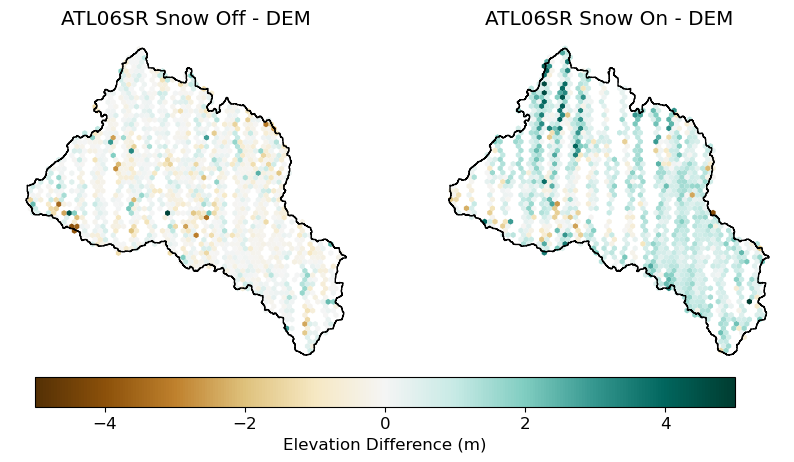

In [214]:
fig, ax = plt.subplots(1,2, figsize=(10,10))

hb_off = ax[0].hexbin(atl06sr_gdf[inner_snowoff_idx].geometry.x, 
               atl06sr_gdf[inner_snowoff_idx].geometry.y, 
               C=atl06sr_gdf[inner_snowoff_idx]['diff_plus'], 
               reduce_C_function=np.median, gridsize=60, cmap = 'BrBG', 
               mincnt=0.0001, vmin=-5, vmax=5, edgecolors='none')

hb_on = ax[1].hexbin(atl06sr_gdf[inner_snowon_idx].geometry.x, 
               atl06sr_gdf[inner_snowon_idx].geometry.y, 
               C=atl06sr_gdf[inner_snowon_idx]['diff_plus'], 
               reduce_C_function=np.median, gridsize=60, cmap = 'BrBG', 
               mincnt=0.0001, vmin=-5, vmax=5, edgecolors='none')

outline_gdf.plot(ax=ax[0], facecolor='none', edgecolor='k')
outline_gdf.plot(ax=ax[1], facecolor='none', edgecolor='k')

for axis in ax:
    axis.set_axis_off()

# https://stackoverflow.com/questions/13784201/how-to-have-one-colorbar-for-all-subplots
fig.subplots_adjust(top=0.8)
cbar_ax = fig.add_axes([0.15, 0.25, 0.7, 0.03])
plt.colorbar(hb_on, cax=cbar_ax, label='Elevation Difference (m)', orientation='horizontal')

#plt.tight_layout()
ax[0].set_title('ATL06SR Snow Off - DEM')
ax[1].set_title('ATL06SR Snow On - DEM')

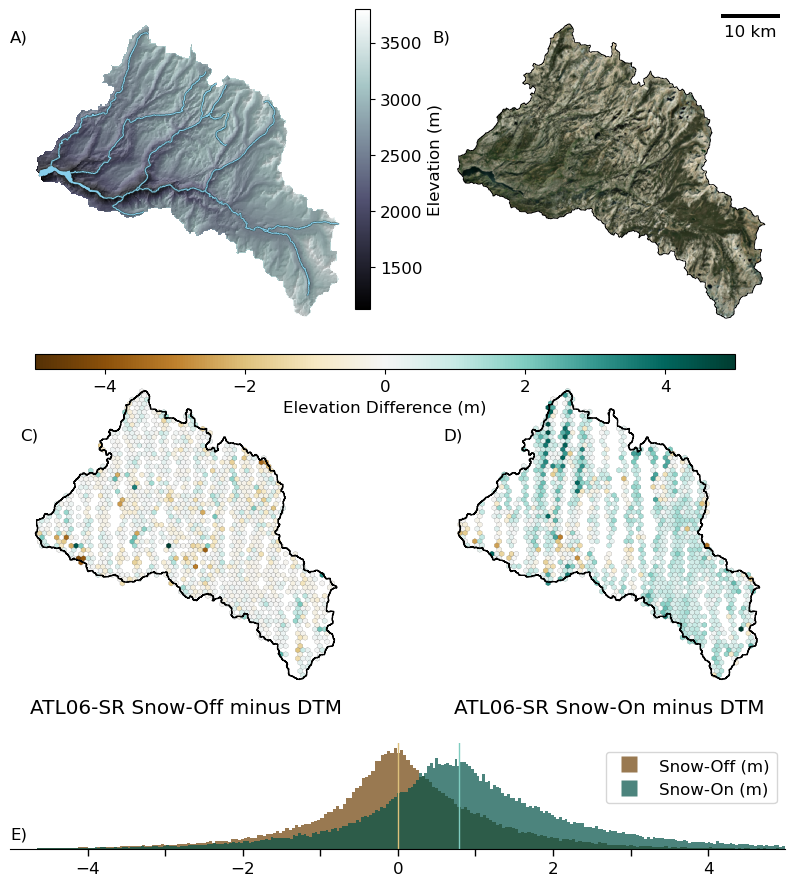

In [48]:
# With combined histograms

basemap = cx.providers.Esri.WorldImagery

# add histograms to difference plots
norm = matplotlib.colors.Normalize(vmin=-5, vmax=5)
cmap = matplotlib.cm.get_cmap('BrBG')

fig, ax = plt.subplot_mosaic([['a', 'b'],
                             ['c', 'd'],
                             ['e', 'e']], figsize=(10,10), gridspec_kw={'height_ratios': [3, 3, 1], 'width_ratios': [1,1]})

c = dtm.plot(cmap='bone', ax=ax['a'], add_colorbar=False) # , cbar_kwargs={'label':'Elevation (m)'}
#chm.plot(cmap='Greens', ax=ax[0,0], add_colorbar=True, vmin=0, vmax=20, cbar_kwargs={'label':'Canopy Height (m)','shrink':0.9}, alpha=0.8)
hillshade.plot(cmap='Greys', ax=ax['a'], add_colorbar=False, alpha=0.3)
streamlines_tuol.plot(ax=ax['a'], color='darkslategrey', linewidth=1.5, alpha=0.8, zorder=1)
streamlines_tuol.plot(ax=ax['a'], color='skyblue', linewidth=0.75, alpha=1, zorder=5)
hetch.plot(ax=ax['a'], color='skyblue', alpha=1,zorder=10)
ax['a'].set_xlim(250000, 310000)
ax['a'].set_ylim(4178000, 4232000)
ax['a'].set_axis_off()
ax['a'].set_title('')
ax['a'].annotate(text='A)', xy=(0,0.9), xycoords='axes fraction')

#ax[0,1].set_axis_off()
ax['b'].set_title('')
#c.set_label('Canopy Height(m)')
#ig.colorbar(c, label = 'Canopy Height (m)')

ax['b'].add_artist(ScaleBar(1))
outline_gdf.plot(ax=ax['b'], facecolor='none', edgecolor='k')
cx.add_basemap(ax['b'], attribution=False, crs=atl06sr_gdf.crs.to_string(), source=basemap, zoom=12)
tuol_reverse.plot(ax=ax['b'], facecolor='white')
ax['b'].set_xlim(250000, 310000)
ax['b'].set_ylim(4178000, 4232000)
ax['b'].axes.xaxis.set_ticks([])
ax['b'].axes.yaxis.set_ticks([])
ax['b'].annotate(text='B)', xy=(0,0.9), xycoords='axes fraction')

hb_off = ax['c'].hexbin(atl06sr_gdf_inner[atl06sr_gdf_inner['snow_presence']==0].geometry.x, 
               atl06sr_gdf_inner[atl06sr_gdf_inner['snow_presence']==0].geometry.y, 
               C=atl06sr_gdf_inner[atl06sr_gdf_inner['snow_presence']==0]['diff_plus_bicubic'], 
               reduce_C_function=np.median, gridsize=60, cmap = 'BrBG', 
               mincnt=0.0001, vmin=-5, vmax=5, edgecolors='k', linewidth=.075)
ax['c'].set_axis_off()
ax['c'].annotate(text='C)', xy=(0,0.8), xycoords='axes fraction')

hb_on = ax['d'].hexbin(atl06sr_gdf_inner[atl06sr_gdf_inner['snow_presence']==1].geometry.x, 
               atl06sr_gdf_inner[atl06sr_gdf_inner['snow_presence']==1].geometry.y, 
               C=atl06sr_gdf_inner[atl06sr_gdf_inner['snow_presence']==1]['diff_plus_bicubic'], 
               reduce_C_function=np.median, gridsize=60, cmap = 'BrBG', 
               mincnt=0.0001, edgecolors='k', linewidth=.075, vmin=-5, vmax=5)
ax['d'].set_axis_off()
ax['d'].annotate(text='D)', xy=(0,0.8), xycoords='axes fraction')

outline_gdf.plot(ax=ax['c'], facecolor='none', edgecolor='k')
outline_gdf.plot(ax=ax['d'], facecolor='none', edgecolor='k')

ax['e'].hist(atl06sr_gdf_inner[atl06sr_gdf_inner['snow_presence']==0]['diff_plus_bicubic'], color=cmap(norm(-4.5)),\
            bins=250, alpha=0.7)
ax['e'].axvline(x = np.nanmedian(atl06sr_gdf_inner[atl06sr_gdf_inner['snow_presence']==0]['diff_plus_bicubic']), c=cmap(norm(-2)), linewidth=1)
ax['e'].tick_params('both', length=5, width=1, which='major')
ax['e'].tick_params('both', length=5, width=1, which='minor')
#add lines for the standard deviation
# ax['e'].axvline(x = np.nanmedian(atl06sr_gdf[inner_snowoff_idx]['diff_plus']) + 
#                 np.nanstd(atl06sr_gdf[inner_snowoff_idx]['diff_plus']), c=cmap(norm(-1)), linewidth=0.5)
# ax['e'].axvline(x = np.nanmedian(atl06sr_gdf[inner_snowoff_idx]['diff_plus']) - 
#                 np.nanstd(atl06sr_gdf[inner_snowoff_idx]['diff_plus']), c=cmap(norm(-1)), linewidth=0.5)

#ax[1,0].set_xlabel('Snowoff Elevation Differences (m)')
# Hide the right and top spines
ax['e'].spines.right.set_visible(False)
ax['e'].spines.top.set_visible(False)
ax['e'].spines.left.set_visible(False)
ax['e'].axes.yaxis.set_visible(False)
ax['e'].set_xlim(-5,4.99)
ax['e'].annotate(text='E)', xy=(0,0.1), xycoords='axes fraction')
# ax[2,0].text(x=np.nanmedian(atl06sr_gdf[inner_snowoff_idx]['diff_plus']) + 
#                 np.nanstd(atl06sr_gdf[inner_snowoff_idx]['diff_plus']), y=0, s='std')
# ax[2,0].text(x=np.nanmedian(atl06sr_gdf[inner_snowoff_idx]['diff_plus']), y=0, s='median')

ax['e'].hist(atl06sr_gdf_inner[atl06sr_gdf_inner['snow_presence']==1]['diff_plus_bicubic'], color=cmap(norm(4.5)),\
            bins=290, alpha=0.7)
ax['e'].axvline(x = np.nanmedian(atl06sr_gdf_inner[atl06sr_gdf_inner['snow_presence']==1]['diff_plus_bicubic']), c=cmap(norm(2)), linewidth=1)
#ax['e'].set_xticks([-5,-4,-3,-2,-1,0,1,2,3,4,5])

#Add minor ticks between the labels
minor_locator = AutoMinorLocator(2)
ax['e'].xaxis.set_minor_locator(minor_locator)

# MAKE A LEGEND
custom = [Line2D([], [], marker='s', markersize=12, markeredgecolor='none', color=cmap(norm(-4.5), alpha=0.7), linestyle='None'),
        Line2D([], [], marker='s', markersize=12, markeredgecolor='none', color=cmap(norm(4.5), alpha=0.7), linestyle='None')
          ]
custom_labels = ['Snow-Off (m)', 'Snow-On (m)']

ax['e'].legend(custom, custom_labels, loc='upper right')

# ax['e'].axvline(x = np.nanmedian(atl06sr_gdf[inner_snowon_idx]['diff_plus']) + 
#                 np.nanstd(atl06sr_gdf[inner_snowon_idx]['diff_plus']), c=cmap(norm(1)), linewidth=0.5)
# ax['e'].axvline(x = np.nanmedian(atl06sr_gdf[inner_snowon_idx]['diff_plus']) -
#                 np.nanstd(atl06sr_gdf[inner_snowon_idx]['diff_plus']), c=cmap(norm(1)), linewidth=0.5)

#ax[1,1].set_xlabel('Snow On Elevation Differences (m)')
# ax[2,1].spines.right.set_visible(False)
# ax[2,1].spines.top.set_visible(False)
# ax[2,1].spines.left.set_visible(False)
# ax[2,1].axes.yaxis.set_visible(False)
# ax[2,1].annotate(text='F)', xy=(0,0.1), xycoords='axes fraction')

# https://stackoverflow.com/questions/13784201/how-to-have-one-colorbar-for-all-subplots
fig.subplots_adjust(top=0.95) #0.8
cbar_ax = fig.add_axes([0.15, 0.59, 0.7, 0.015])
plt.colorbar(hb_on, cax=cbar_ax, label='Elevation Difference (m)', orientation='horizontal')
cbar_ax2 = fig.add_axes([0.47, 0.65, 0.015, 0.3]) #.46
plt.colorbar(c, cax=cbar_ax2, label='Elevation (m)', orientation='vertical')

#plt.tight_layout()
ax['c'].set_title('ATL06-SR Snow-Off minus DTM', y=0, pad=-14)
ax['d'].set_title('ATL06-SR Snow-On minus DTM', y=0, pad=-14)

for ax in [ax['a'], ax['b']]:
        ax.spines['bottom'].set_color('white')
        ax.spines['top'].set_color('white')
        ax.spines['left'].set_color('white')
        ax.spines['right'].set_color('white')
        ax.axes.get_xaxis().set_ticks([])
        ax.axes.get_yaxis().set_ticks([])
        
    

#plt.tight_layout()
plt.savefig('../../figures/polished/difference_map_hist_w-hillshade.jpeg', dpi=500)

### Determine skew of the snow on and off histograms:

In [15]:
scipy.stats.skew(atl06sr_gdf_inner[atl06sr_gdf_inner['snow_presence']==0]['diff_plus_bicubic'], nan_policy='omit')

0.01757830814338745

In [16]:
scipy.stats.skewtest(atl06sr_gdf_inner[atl06sr_gdf_inner['snow_presence']==0]['diff_plus_bicubic'], nan_policy='omit')

SkewtestResult(statistic=1.7998288102306337, pvalue=0.07188767330960434)

In [17]:
scipy.stats.skew(atl06sr_gdf_inner[atl06sr_gdf_inner['snow_presence']==1]['diff_plus_bicubic'], nan_policy='omit')

0.02266663322042124

In [18]:
scipy.stats.skewtest(atl06sr_gdf_inner[atl06sr_gdf_inner['snow_presence']==1]['diff_plus_bicubic'], nan_policy='omit')

SkewtestResult(statistic=2.6842562771371936, pvalue=0.007269136162246597)